In [97]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder


In [98]:
# Load the Excel file
file_path = "2024_PersonalityTraits_SurveyData.xls" 
df = pd.read_excel(file_path)


In [99]:
# Define the target feature
target_feature = "What cigarette brand(s) are you currently using?"

# Encode the target feature
df[target_feature] = df[target_feature].astype('category').cat.codes


/home/moegho/venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/moegho/venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_9151/1553304208.py:34: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


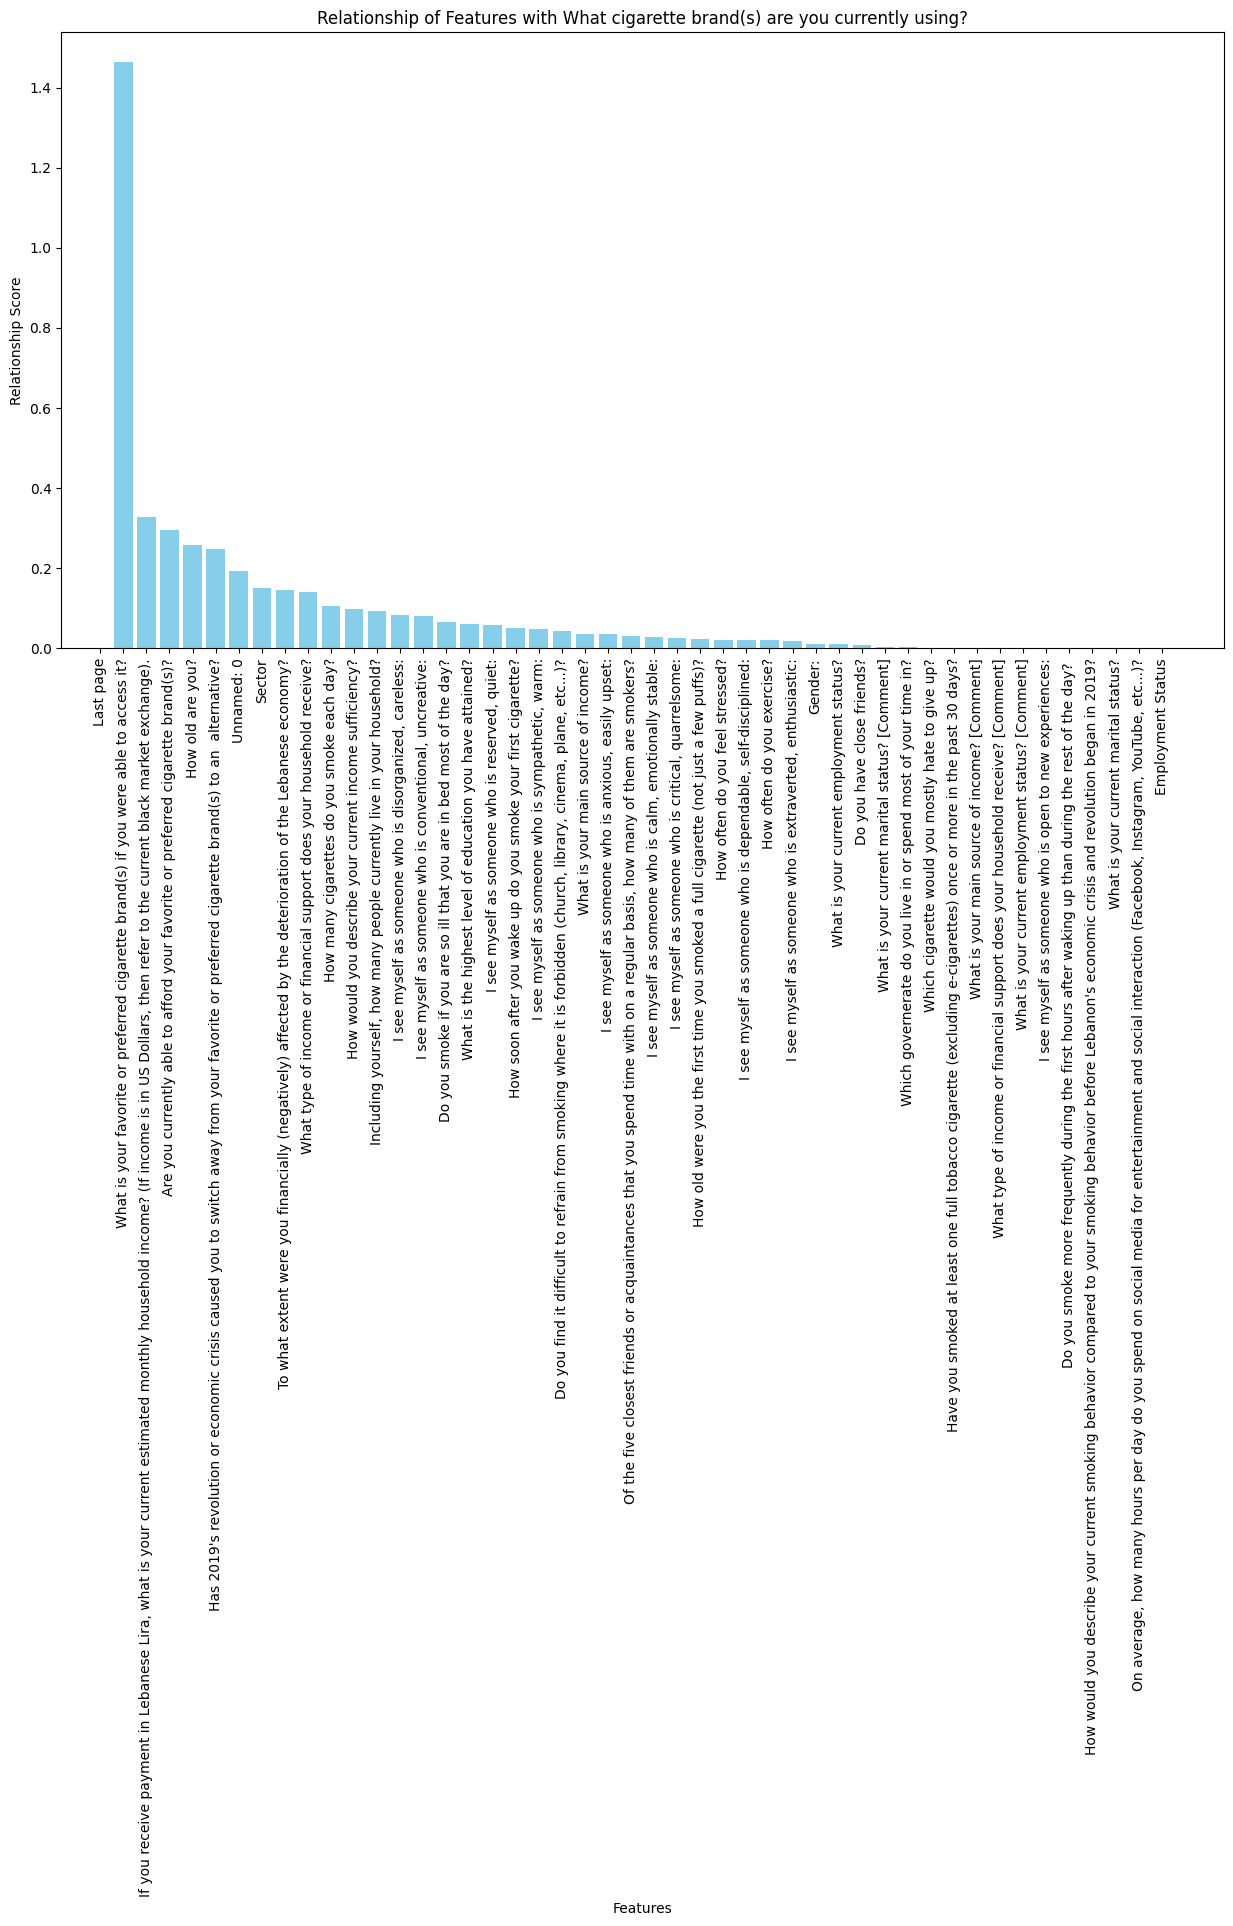

In [100]:
# Separate numerical and categorical features
numeric_features = df.select_dtypes(include=['number']).columns
categorical_features = df.select_dtypes(include=['object', 'category']).columns

# Explicitly exclude the target feature from categorical features
categorical_features = [feature for feature in categorical_features if feature != target_feature]

# Initialize a dictionary to store scores
feature_scores = {}

# Calculate correlation for numerical features
for feature in numeric_features:
    if feature != target_feature:  # Skip the target feature
        correlation = df[feature].corr(df[target_feature])
        feature_scores[feature] = abs(correlation)  # Use absolute value of correlation

# Calculate mutual information for categorical features
for feature in categorical_features:
    df[feature] = df[feature].astype('category').cat.codes  # Encode as numeric
    mutual_info = mutual_info_regression(df[[feature]], df[target_feature], discrete_features=True)
    feature_scores[feature] = mutual_info[0]

# Sort features by their scores
sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)

# Plot the scores
features, scores = zip(*sorted_features)
plt.figure(figsize=(15, 8))
plt.bar(features, scores, color='skyblue')
plt.xticks(rotation=90)
plt.title(f"Relationship of Features with {target_feature}")
plt.xlabel("Features")
plt.ylabel("Relationship Score")
plt.tight_layout()
plt.show()

In [101]:
# Filter features with non-zero relationship
non_zero_features = {feature: score for feature, score in feature_scores.items() if score > 0}
filtered_features = list(non_zero_features.keys()) + [target_feature]
df = df[filtered_features]

# Encode the target feature
df[target_feature] = df[target_feature].astype('category').cat.codes

# Step 2: Feature Relationship Analysis (Skipping for brevity; define X and y here)
X = df.drop(columns=[target_feature])
y = df[target_feature]

# Normalize numerical features
scaler = StandardScaler()
numeric_features = X.select_dtypes(include=['number']).columns
X[numeric_features] = scaler.fit_transform(X[numeric_features])


In [102]:
# Sanitize feature names
X.columns = [str(col).replace("[", "").replace("]", "").replace("<", "").replace(">", "").replace(" ", "_") for col in X.columns]

# Apply SMOTE and Random Oversampling
smote = SMOTE(random_state=42, k_neighbors=1)
ros = RandomOverSampler(random_state=42)

X_resampled, y_resampled = ros.fit_resample(X, y)
X_resampled, y_resampled = smote.fit_resample(X_resampled, y_resampled)

# Sanitize feature names again after resampling
X_resampled.columns = [str(col).replace("[", "").replace("]", "").replace("<", "").replace(">", "").replace(" ", "_") for col in X_resampled.columns]


# Verify class distribution after resampling
print("Class distribution after resampling:")
print(pd.Series(y_resampled).value_counts())



Class distribution after resampling:
What cigarette brand(s) are you currently using?
29    32
20    32
9     32
75    32
60    32
      ..
27    32
95    32
68    32
64    32
62    32
Name: count, Length: 97, dtype: int64


In [103]:

# Step 4: Modeling
# Split resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)


In [104]:
# Define XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)


In [105]:
# Define parameter grid for randomized search
param_distributions = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "gamma": [0, 0.1],
    "reg_alpha": [0, 0.1],
    "reg_lambda": [1, 0.1],
}

# Perform Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=10,
    scoring="accuracy",
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:46:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:46:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:46:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:46:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:46:40] WARNING: /workspace/src/learner.

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.2s


/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:46:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:46:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.4s


/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:46:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:46:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:46:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:46:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=100, reg_alpha=0, reg_lambda=0.1, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=100, reg_alpha=0, reg_lambda=0.1, subsample=1.0; total time=   2.3s


/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:46:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:46:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=100, reg_alpha=0, reg_lambda=0.1, subsample=1.0; total time=   2.3s


/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:46:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=0.1, subsample=1.0; total time=   2.3s


/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:46:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=1.0; total time=   3.7s


/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:46:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=1.0; total time=   4.2s


/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:46:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=0.1, subsample=1.0; total time=   2.5s


/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:46:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=1.0; total time=   4.9s


/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:46:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=   5.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=   5.3s


/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:46:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:46:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=0.1, subsample=1.0; total time=   2.3s


/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:46:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, reg_alpha=0.1, reg_lambda=0.1, subsample=1.0; total time=   5.1s


/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:46:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=50, reg_alpha=0.1, reg_lambda=1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=50, reg_alpha=0.1, reg_lambda=1, subsample=1.0; total time=   1.4s


/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:46:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:46:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:46:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   3.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=0.1, subsample=0.8; total time=   2.8s


/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:46:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=0.1, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=0.1, subsample=0.8; total time=   2.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=50, reg_alpha=0.1, reg_lambda=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   4.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=2

/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:46:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learnin...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'gamma': [0, 0.1],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200],
                                        'reg_alpha': [0, 0.1],
                                        'reg_lambda': [1, 0.1],
                                        'subsample': [0.8, 1.0]},
                   random_state=42, scoring='accuracy', verbose=2)

In [106]:
# Evaluate the model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Best Parameters:", random_search.best_params_)
print("Classification Report:\n", classification_report(y_test, y_pred))

Best Parameters: {'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         6
           7       1.00      1.00      1.00         6
           8       1.00      1.00      1.00         6
           9       1.00      1.00      1.00         6
          10       1.00      1.00      1.00         6
          11       1.00      1.00      1.00         6
          12       1.00      1.00      1.00         6
          13       1.00      1.00      1.00       

In [108]:
# Evaluate on the training set
y_train_pred = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

print("Training Set Metrics:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-Score: {train_f1:.4f}")

# Evaluate on the test set
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print("\nTest Set Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")

Training Set Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Test Set Metrics:
Accuracy: 0.9952
Precision: 0.9956
Recall: 0.9952
F1-Score: 0.9950


/home/moegho/venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/moegho/venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_9151/219217381.py:60: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


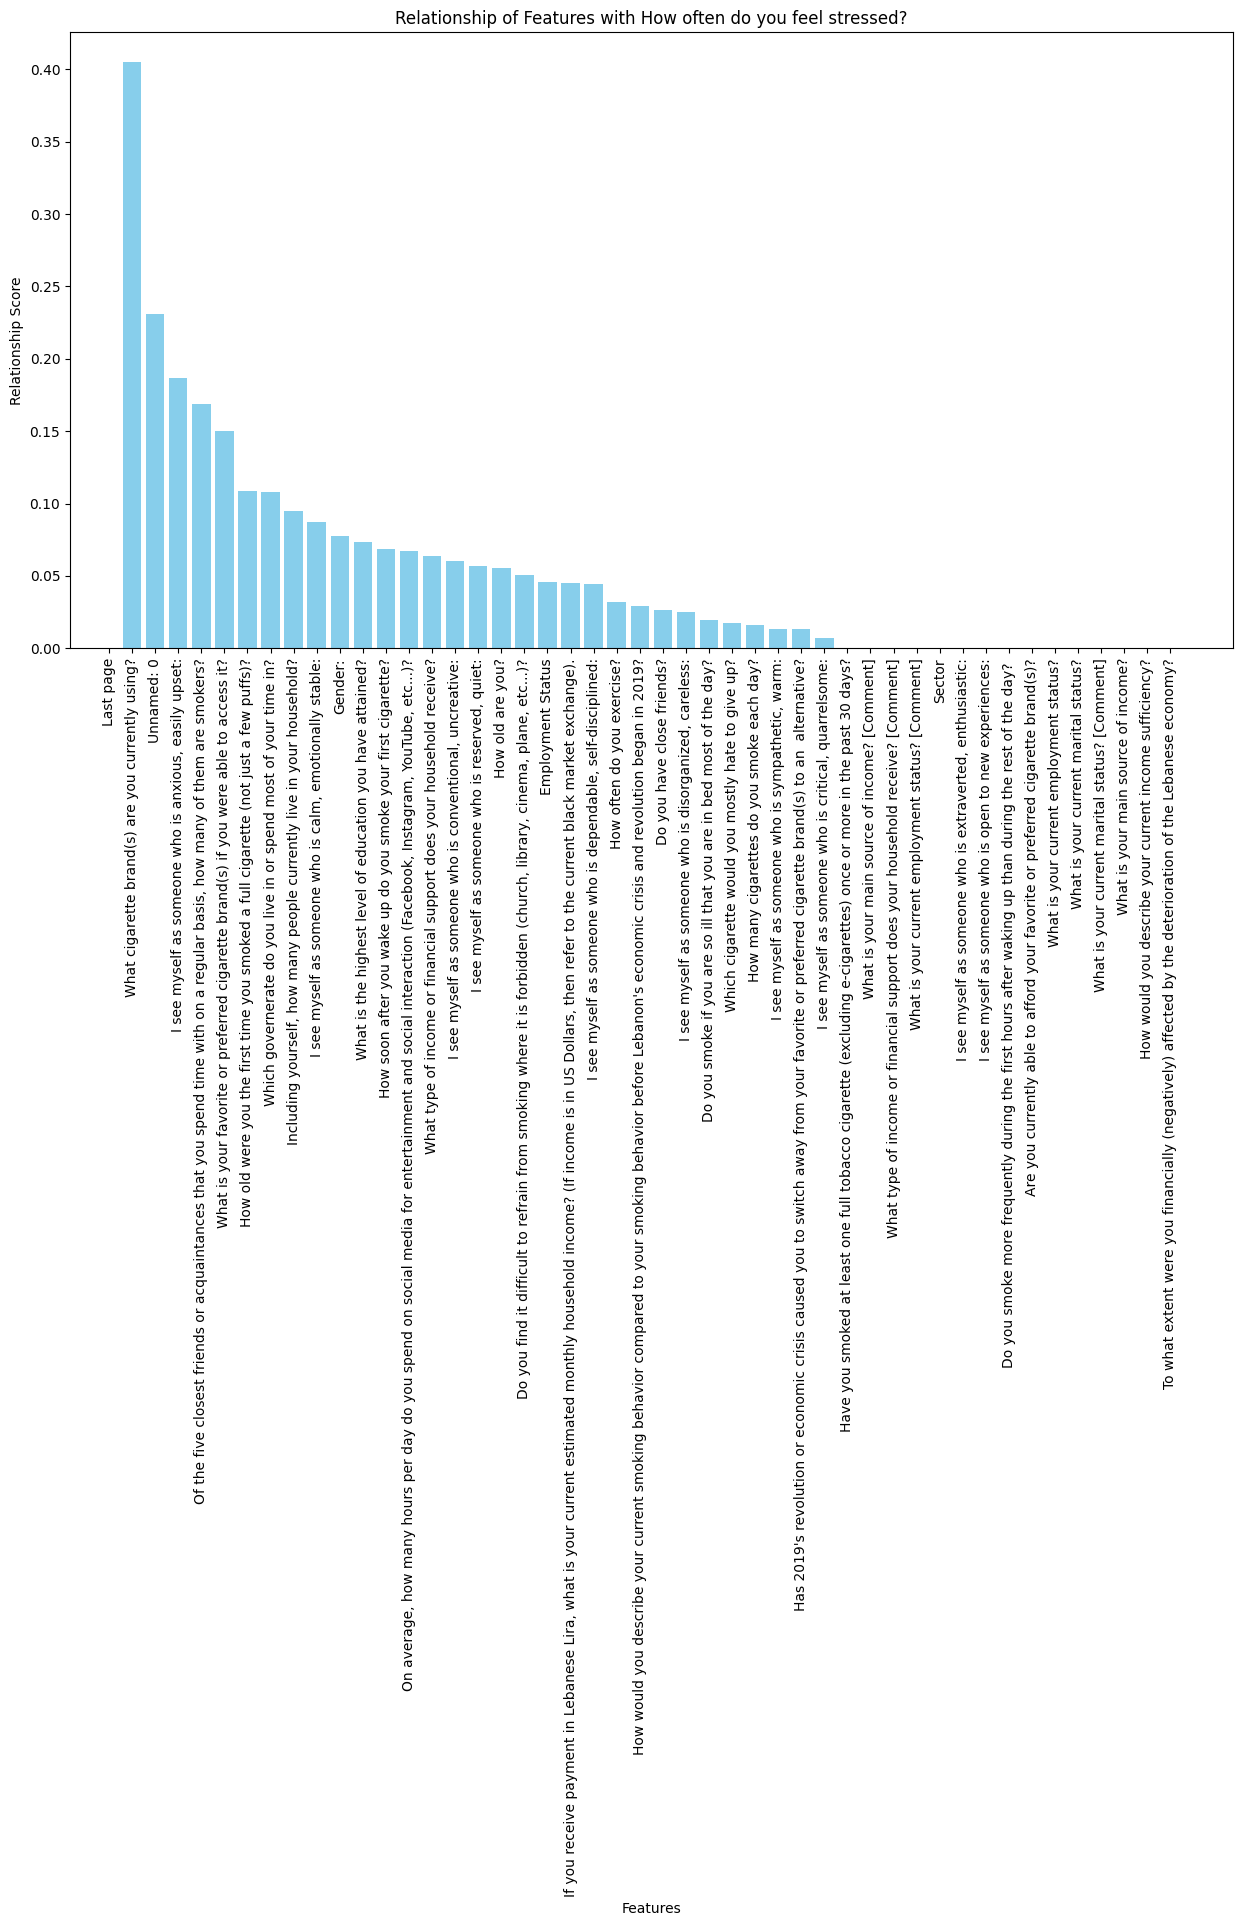

In [109]:
# Load the Excel file
file_path = "2024_PersonalityTraits_SurveyData.xls" 
df = pd.read_excel(file_path)


# Define the target feature
target_feature = "How often do you feel stressed?"


# Check if the column exists
if target_feature in df.columns:
    # Encode the target feature
    df[target_feature] = df[target_feature].astype('category').cat.codes

    # Define features and target
    X = df.drop(columns=[target_feature])
    y = df[target_feature]

    # Preprocess categorical features
    categorical_features = X.select_dtypes(include=['object', 'category']).columns
    for feature in categorical_features:
        le = LabelEncoder()
        X[feature] = le.fit_transform(X[feature].astype(str))
else:
    print(f"Target column '{target_feature}' does not exist in the DataFrame.")

# Separate numerical and categorical features
numeric_features = df.select_dtypes(include=['number']).columns
categorical_features = df.select_dtypes(include=['object', 'category']).columns

# Explicitly exclude the target feature from categorical features
categorical_features = [feature for feature in categorical_features if feature != target_feature]

# Initialize a dictionary to store scores
feature_scores = {}

# Calculate correlation for numerical features
for feature in numeric_features:
    if feature != target_feature:  # Skip the target feature
        correlation = df[feature].corr(df[target_feature])
        feature_scores[feature] = abs(correlation)  # Use absolute value of correlation

# Calculate mutual information for categorical features
for feature in categorical_features:
    df[feature] = df[feature].astype('category').cat.codes  # Encode as numeric
    mutual_info = mutual_info_regression(df[[feature]], df[target_feature], discrete_features=True)
    feature_scores[feature] = mutual_info[0]

# Sort features by their scores
sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)

# Plot the scores
features, scores = zip(*sorted_features)
plt.figure(figsize=(15, 8))
plt.bar(features, scores, color='skyblue')
plt.xticks(rotation=90)
plt.title(f"Relationship of Features with {target_feature}")
plt.xlabel("Features")
plt.ylabel("Relationship Score")
plt.tight_layout()
plt.show()


In [110]:
# Normalize numerical features
numeric_features = X.select_dtypes(include=['number']).columns
scaler = StandardScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])


In [111]:
# Step 2: Handle Rare Classes
ros = RandomOverSampler(random_state=42)  # Handles rare classes with random oversampling
X_resampled, y_resampled = ros.fit_resample(X, y)

# Step 3: Apply SMOTE
smote = SMOTE(random_state=42, k_neighbors=1)
X_resampled, y_resampled = smote.fit_resample(X_resampled, y_resampled)

# Step 4: Verify Class Distribution
print("Class distribution after resampling:")
print(pd.Series(y_resampled).value_counts())

Class distribution after resampling:
How often do you feel stressed?
1    88
3    88
0    88
2    88
4    88
Name: count, dtype: int64


In [112]:
# Step 5: Split the Data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)


In [113]:
# Step 1: Define Parameter Grid
param_distributions = {
    "n_estimators": [50, 100, 200, 300],  # Number of trees
    "learning_rate": [0.01, 0.05, 0.1, 0.2],  # Shrinkage
    "max_depth": [3, 5, 7, 10],  # Maximum tree depth
    "min_child_weight": [1, 3, 5],  # Minimum sum of instance weight
    "subsample": [0.6, 0.8, 1.0],  # Subsampling ratio
    "colsample_bytree": [0.6, 0.8, 1.0],  # Feature subsampling
    "gamma": [0, 0.1, 0.2],  # Minimum loss reduction
    "reg_alpha": [0, 0.01, 0.1, 1],  # L1 regularization
    "reg_lambda": [1, 0.1, 0.01],  # L2 regularization
}

# Step 2: Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter combinations to try
    scoring="accuracy",  # Metric to optimize
    cv=3,  # Number of cross-validation folds
    verbose=2,  # Print progress
    random_state=42,
    n_jobs=-1,  # Use all available cores
)

X_train.columns = [str(col).replace("[", "").replace("]", "").replace("<", "").replace(">", "").replace(" ", "_") for col in X_train.columns]
X_test.columns = [str(col).replace("[", "").replace("]", "").replace("<", "").replace(">", "").replace(" ", "_") for col in X_test.columns]


# Step 3: Perform Randomized Search
random_search.fit(X_train, y_train)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:18] WARNING: /workspace/src/learner.

[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=200, reg_alpha=1, reg_lambda=1, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=200, reg_alpha=1, reg_lambda=1, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=200, reg_alpha=1, reg_lambda=1, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=0.1, subsample=1.0; total time=   0.3s


/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:19] WARNING: /workspace/src/learner.

[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=0.1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300, reg_alpha=1, reg_lambda=0.01, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=300, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300, reg_alpha=1, reg_lambda=0.01, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=300, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=300, reg_alp

/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:19] WARNING: /workspace/src/learner.

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300, reg_alpha=1, reg_lambda=0.01, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=10, min_child_weight=1, n_estimators=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=100, reg_alpha=0.01, reg_lambda=0.01, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=10, min_child_weight=1, n_estimators=50, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=100, reg_alpha=0.01, reg_lambda=0.01, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=100, 

/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:19] WARNING: /workspace/src/learner.

[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=10, min_child_weight=3, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0, reg_lambd

/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:19] WARNING: /workspace/src/learner.

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=7, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=0.01, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=50, reg_alpha=0.1, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=50, reg_alpha=0.1, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=50, reg_alpha=0.1, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=200, reg_alpha=1, reg_la

/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:20] WARNING: /workspace/src/learner.

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=10, min_child_weight=3, n_estimators=100, reg_alpha=1, reg_lambda=0.01, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=10, min_child_weight=3, n_estimators=100, reg_alpha=1, reg_lambda=0.01, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=10, min_child_weight=3, n_estimators=100, reg_alpha=1, reg_lambda=0.01, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=7, min_child_weight=1, n_estimators=100, reg_alpha=1, reg_lambda=0.1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=7, min_child_weight=1, n_estimators=100, reg_alpha=1, reg_lambda=0.1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=100, reg_alph

/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:20] WARNING: /workspace/src/learner.

[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, reg_alpha=0.01, reg_lambda=0.1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, reg_alpha=0.01, reg_lambda=0.1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, reg_alpha=0.01, reg_lambda=0.1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=5, n_estimators=200, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=5, n_estimators=200, reg_alpha=1, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=5, n_estimators=200, reg_alpha=1

/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:20] WARNING: /workspace/src/learner.

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=300, reg_alpha=0.01, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=300, reg_alpha=0.01, reg_lambda=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=200, reg_alpha=0.01, reg_lambda=0.1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=200, reg_alpha=0.01, reg_lambda=0.1, subsample=0.8; total time=   0.4s


/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=300, reg_alpha=0.1, reg_lambda=0.1, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=300, reg_alpha=0.1, reg_lambda=0.1, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=200, reg_alpha=0.01, reg_lambda=0.1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=300, reg_alpha=0.1, reg_lambda=0.1, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=50, reg_alpha

/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:21] WARNING: /workspace/src/learner.

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=10, min_child_weight=3, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=10, min_child_weight=3, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=50, reg_alpha=0.1, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=50, reg_alpha=0, reg_

/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:21] WARNING: /workspace/src/learner.

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=300, reg_alpha=1, reg_lambda=0.1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.2, max_depth=7, min_child_weight=5, n_estimators=100, reg_alpha=0.1, reg_lambda=0.01, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.2, max_depth=7, min_child_weight=5, n_estimators=100, reg_alpha=0.1, reg_lambda=0.01, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=300, reg_alpha=1, 

/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:21] WARNING: /workspace/src/learner.

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=10, min_child_weight=5, n_estimators=200, reg_alpha=1, reg_lambda=0.01, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=10, min_child_weight=5, n_estimators=300, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=10, min_child_weight=5, n_estimators=300, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=3, n_estimators=300, reg_alpha=0.01, reg_lambda=0.1, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=10, min_child_weight=5, n_estimators=200, reg_alpha=1, reg_lambda=0.01, subsample=0.8; total time=   0.2s[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=3, n_estimators=300,

/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:21] WARNING: /workspace/src/learner.

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=3, n_estimators=50, reg_alpha=0.1, reg_lambda=0.01, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=10, min_child_weight=3, n_estimators=50, reg_alpha=0.1, reg_lambda=0.01, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=10, min_child_weight=5, n_estimators=200, reg_alpha=0, reg_lambda=0.01, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=10, min_child_weight=5, n_estimators=200, reg_alpha=0, reg_lambda=0.01, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=10, min_child_weight=5, n_estimators=200, reg_alpha=0, reg_lambda=0.01, subsample=0.6; total time=   0.2s


/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:22] WARNING: /workspace/src/learner.

[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=7, min_child_weight=3, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=0.01, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=7, min_child_weight=3, n_estimators=50, reg_alpha=0.01, reg_lambda=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=0.01, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=300, reg_alpha=1, reg_lambda=0.01, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=10, min_child_weight=5, n_estimators=300, reg_alpha=

/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:22] WARNING: /workspace/src/learner.

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.05, max_depth=7, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=0.01, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.05, max_depth=7, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=0.01, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.05, max_depth=7, min_child_weight=5, n_estimators=300, reg_alpha=1, reg_lambda=0.01, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, reg_alpha=0.01, reg_lambda=1, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alp

/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:22] WARNING: /workspace/src/learner.

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=100, reg_alpha=0.1, reg_lambda=0.01, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=100, reg_alpha=0.1, reg_lambda=0.01, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200, reg_alpha=0

/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:22] WARNING: /workspace/src/learner.

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=50, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=50, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=0.01, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=0.01, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=300, reg_alpha=0, reg_lambda=0.01, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=300, reg_al

/home/moegho/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learnin...
                                           random_state=42, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.2],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 10],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [50, 100, 200, 300],
                                        'reg_alpha': [0, 0.01, 0.1, 1],
                                        'reg_lambda': [1, 0.1, 0.01],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='accuracy', verbose=2)

In [114]:
# Step 4: Print Best Parameters and Evaluate
best_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

# Step 5: Evaluate on Training and Test Sets
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Training Metrics
print("\nTraining Metrics:")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Precision: {precision_score(y_train, y_train_pred, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_train, y_train_pred, average='weighted'):.4f}")
print(f"F1-Score: {f1_score(y_train, y_train_pred, average='weighted'):.4f}")

# Test Metrics
print("\nTest Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred, average='weighted'):.4f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred, average='weighted'):.4f}")

# Classification Report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))


Best Parameters: {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.6}

Training Metrics:
Accuracy: 0.9972
Precision: 0.9972
Recall: 0.9972
F1-Score: 0.9972

Test Metrics:
Accuracy: 0.8750
Precision: 0.8832
Recall: 0.8750
F1-Score: 0.8709

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       0.91      0.59      0.71        17
           2       1.00      1.00      1.00        18
           3       0.67      0.78      0.72        18
           4       0.89      1.00      0.94        17

    accuracy                           0.88        88
   macro avg       0.88      0.87      0.87        88
weighted avg       0.88      0.88      0.87        88

